In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append("../..") # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

No joblib
no cmocean


In [2]:
# ==============================================================================
# Running this file loads tracers from old FESOM-REcoM2 output file (oce.mean.nc)
# and saves each tracer in an individual file
# 
#  Input:
#  - mesh_id: Name of mesh, will be added to the netcdf name
#  - meshpath: Speciefies where the target mesh is stored
#  - save_netcdf: If true, netcdf will be created
#  - delete_old_netcdf: If a netcdf file with the same name exists, a new cannot 
#    be made. If set to true, an old netcdf with the same name will be deleted
#
#  Output:
#  - netcdf file for each tracer in the old file
#  
#  During running, keep an eye on the output in the terminal, to see if it 
#  makes sense. 
#
# ==============================================================================

In [3]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'rv100m'
first_year = 2014
last_year  = 2014
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'
months =np.linspace(0,11,12).astype(int)

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [4]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/' # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'
plot_netcdf       = True                                           # Reads DIN from the created netcdf file, else it plots the interpolated field (should be the same)

In [5]:
ind = np.max(np.argwhere(mesh.zlevs == 100))
ind_depth = np.array(mesh.n32[:,ind]) # depth max 580m

In [6]:
from derivative import derivative

bafux_2d, bafuy_2d = derivative(mesh)
f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)

Starting derivative calculation
Derivative calculated


In [10]:

for ind in range(0,len(years)):
    netcdf_name       = tracername+'.'+str(years[ind])+'.monthly.nc'
    print(years[ind])
    # ==============================================================================
    # Loading data
    ncfile	= input_directory+runid+'/'+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f	= Dataset(ncfile,'r')
    #tracer	= f.variables[tracername][:]
    tracer1	= f.variables['u'][:]
    tracer2	= f.variables['v'][:]
    date = f.variables['time'][:]
    RV = np.zeros((len(date),len(mesh.x2)))
        
    for day in range(0,len(date)):
        print(day)
        u = tracer1[day,ind_depth]
        v = tracer2[day,ind_depth]
        #(u_rot,v_rot)   = pf.vec_rotate_r2g(mesh.x2, mesh.y2, u, v)
        (u_rot,v_rot)   = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, u, v, flag=1)
        rv_elem = np.sum(v_rot[mesh.elem] * bafux_2d,axis=1)-np.sum(u_rot[mesh.elem] * bafuy_2d, axis=1) #over triangle
        
        rv_node = np.zeros(len(mesh.x2))
        ind_cnt = np.zeros(len(mesh.x2))
        for ii in range(0,len(mesh.elem)):
            nod_elem=mesh.elem[ii,:]
            rv_node[nod_elem]=rv_node[nod_elem]+rv_elem[ii]
            ind_cnt[nod_elem]=ind_cnt[nod_elem]+1.
    
        RV[day,:] = rv_node/ind_cnt/f0

    tracershape = np.shape(RV)

    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = 'current speed at surface'
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod3d    = w_nc_fid.createDimension('nod2d', mesh.n2d)               # Create dimension: number of 3d nodes
      time	   = w_nc_fid.createDimension('time', tracershape[0]) 

      w_nc_var = w_nc_fid.createVariable(tracername, 'f4',('time','nod2d'))           # 'DIN' is name of saved variable
                                                                           # 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'Relative vorticity',\
                          'units': u'no unit'})
      w_nc_fid.variables[tracername][:] = RV
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'

2014
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
The netcdf file rv100m.2014.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( rv100m.2014.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/


In [57]:
# ind = np.max(np.argwhere(mesh.zlevs == 100))
# ind_depth = np.array(mesh.n32[:,ind]) # depth max 580m

# day = 50
# u = tracer1[day,ind_depth]
# v = tracer2[day,ind_depth]

# (u_rot,v_rot)   = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, u, v, flag=1)
# rv_elem = np.sum(v_rot[mesh.elem] * bafux_2d,axis=1)-np.sum(u_rot[mesh.elem] * bafuy_2d, axis=1) #over triangle
        
# rv_node = np.zeros(len(mesh.x2))
# ind_cnt = np.zeros(len(mesh.x2))
# for ii in range(0,len(mesh.elem)):
#     nod_elem=mesh.elem[ii,:]
#     rv_node[nod_elem]=rv_node[nod_elem]+rv_elem[ii]
#     ind_cnt[nod_elem]=ind_cnt[nod_elem]+1.
    
# RV[day,:] = rv_node/ind_cnt/f0

For depth 0 model level -0.0 will be used


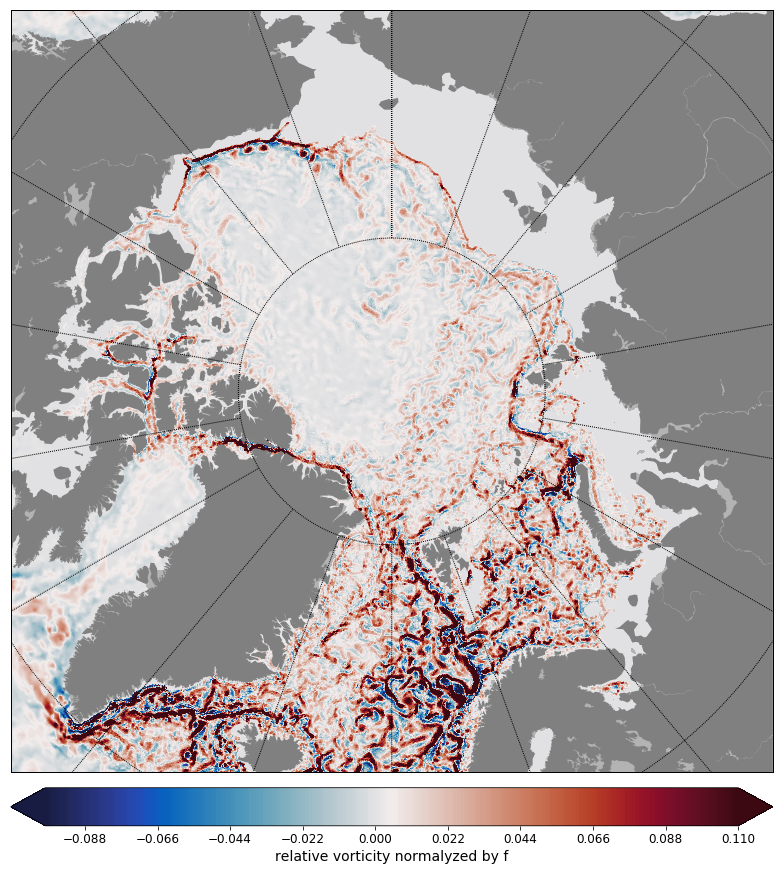

In [9]:
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

#MLD_sept_mean[MLD_sept_mean == 0] = np.nan
data, elem_no_nan = pf.get_data(RV[0,:],mesh,0)
ax1      = fig.add_subplot(111)
contours = np.arange(-.1, .11, .001)
m = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'relative vorticity normalyzed by f'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

For depth 0 model level -0.0 will be used


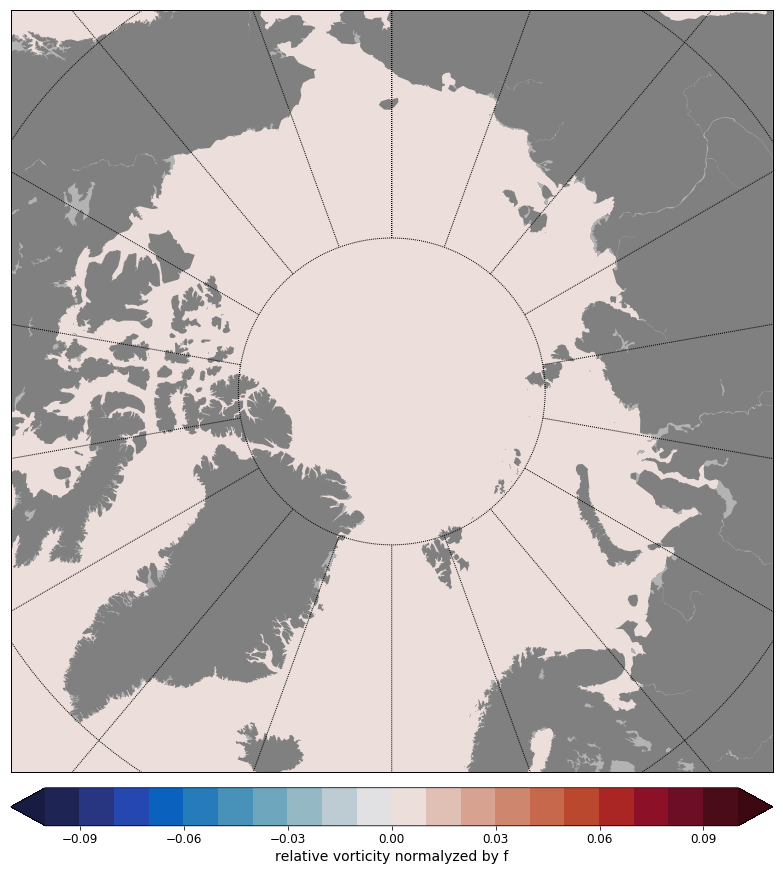

In [59]:
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

#MLD_sept_mean[MLD_sept_mean == 0] = np.nan
data, elem_no_nan = pf.get_data(RV[day+1,:],mesh,0)
ax1      = fig.add_subplot(111)
contours = np.arange(-.1, .11, .01)
m = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'relative vorticity normalyzed by f'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)